In [9]:
#Import All libraries 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import optuna
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning.losses import SupConLoss
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
#Define image transformations (including normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full MNIST training set
full_train_data = datasets.MNIST(root="D:\MNIST\MNIST_Train", train=True, download=False, transform = transform)
test_data = datasets.MNIST(root="D:\MNIST\MNIST_Test", train=False, download=False, transform= transform)

# Set the seed for reproducibility
torch.manual_seed(42)  # You can choose any seed number

# Define train-validation split sizes
train_size = int(0.8 * len(full_train_data))  # 80% for training
val_size = len(full_train_data) - train_size  # 20% for validation

# Split the full training dataset
train_data, val_data = random_split(full_train_data, [train_size, val_size])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CNNEncoder(nn.Module): #Encoder as we're only interest in the final embedding provided by the CNN 
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(256 * 7 * 7, 128)  # Output: 128-dimension embeddings

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 7x7
        
        x = x.view(-1, 256 * 7 * 7)  # Flatten
        x = self.fc(x)  # Output embeddings
        return x

class MLPClassifier(nn.Module): # MLP projection Head 
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Initialize accuracy calculator
#accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), knn_func=None)

class ContrastiveTrainer:
    def __init__(self, encoder, classifier, criterion, optimizer):
        self.encoder = encoder
        self.classifier = classifier
        self.criterion = criterion
        self.optimizer = optimizer

    def train_contrastive(self, train_loader, epochs=10):
        self.encoder.train()
        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Forward pass through the encoder
                features = self.encoder(images)

                # Compute supervised contrastive loss
                loss = self.criterion(features, labels)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            print(f'Epoch [{epoch + 1}/{epochs}], Contrastive Loss: {total_loss / len(train_loader):.4f}')
    
    def train_classifier(self, train_loader, epochs=5):
        self.encoder.eval()  # Freeze the encoder for classifier training
        self.classifier.train()
        
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Extract frozen features
                with torch.no_grad():
                    features = self.encoder(images)

                # Forward pass through the classifier
                outputs = self.classifier(features)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

            accuracy = correct / len(train_loader.dataset)
            print(f'Epoch [{epoch + 1}/{epochs}], Classification Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%')

   # def evaluate_embeddings(self, test_loader):
    #    self.encoder.eval()
   #     all_embeddings = []
  #      all_labels = []
#
  #      with torch.no_grad():
     #       for images, labels in test_loader:
    #            images, labels = images.to(device), labels.to(device)
      #          features = self.encoder(images)
      #          
       #         all_embeddings.append(features.cpu())
       #         all_labels.append(labels.cpu())
#
        #all_embeddings = torch.cat(all_embeddings)
       # all_labels = torch.cat(all_labels)

       # print(accuracy_calculator.get_accuracy(all_embeddings, all_labels, all_embeddings, all_labels))

    def test_classifier(self, test_loader):
            self.encoder.eval()
            self.classifier.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    features = self.encoder(images)
                    outputs = self.classifier(features)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'Test Accuracy: {100 * correct / total:.2f}%')



In [5]:
# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    encoder = CNNEncoder().to(device)
    classifier = MLPClassifier().to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
    contrastive_loss = SupConLoss().to(device)
    
    trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)
    
    # Train the model
    trainer.train_contrastive(train_loader, epochs=5)  # Train for fewer epochs for tuning speed
    trainer.train_classifier(train_loader, epochs=3)
    
    # Evaluate on validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [6]:
# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-10-15 15:24:23,035] A new study created in memory with name: no-name-83067d3d-f3c1-4beb-bdb2-f9228388e3f1


Epoch [1/5], Contrastive Loss: 2.2075
Epoch [2/5], Contrastive Loss: 1.9806
Epoch [3/5], Contrastive Loss: 1.9242
Epoch [4/5], Contrastive Loss: 1.8911
Epoch [5/5], Contrastive Loss: 1.8701
Epoch [1/3], Classification Loss: 2.2975, Accuracy: 9.90%
Epoch [2/3], Classification Loss: 2.2809, Accuracy: 15.50%
Epoch [3/3], Classification Loss: 2.2596, Accuracy: 32.17%


[I 2024-10-15 16:26:42,989] Trial 0 finished with value: 0.36491666666666667 and parameters: {'lr': 1.9586116348528246e-05, 'batch_size': 64}. Best is trial 0 with value: 0.36491666666666667.


Epoch [1/5], Contrastive Loss: 2.1273
Epoch [2/5], Contrastive Loss: 1.9237
Epoch [3/5], Contrastive Loss: 1.8745
Epoch [4/5], Contrastive Loss: 1.8475
Epoch [5/5], Contrastive Loss: 1.8267
Epoch [1/3], Classification Loss: 2.2882, Accuracy: 14.98%
Epoch [2/3], Classification Loss: 2.2314, Accuracy: 32.24%
Epoch [3/3], Classification Loss: 2.1375, Accuracy: 71.37%


[I 2024-10-15 17:25:35,697] Trial 1 finished with value: 0.79225 and parameters: {'lr': 4.20183167702627e-05, 'batch_size': 64}. Best is trial 1 with value: 0.79225.


Best hyperparameters:  {'lr': 4.20183167702627e-05, 'batch_size': 64}


In [7]:
# Use best hyperparameters to train the final model
best_params = study.best_params
train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

# 
encoder = CNNEncoder().to(device)
classifier = MLPClassifier().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=best_params['lr'])
contrastive_loss = SupConLoss().to(device)


trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)

# Final training and testing
trainer.train_contrastive(train_loader, epochs=10)
trainer.train_classifier(train_loader, epochs=5)
trainer.test_classifier(test_loader)


Epoch [1/10], Contrastive Loss: 2.1306
Epoch [2/10], Contrastive Loss: 1.9258
Epoch [3/10], Contrastive Loss: 1.8728
Epoch [4/10], Contrastive Loss: 1.8443
Epoch [5/10], Contrastive Loss: 1.8262
Epoch [6/10], Contrastive Loss: 1.8112
Epoch [7/10], Contrastive Loss: 1.8028
Epoch [8/10], Contrastive Loss: 1.7948
Epoch [9/10], Contrastive Loss: 1.7868
Epoch [10/10], Contrastive Loss: 1.7810
Epoch [1/5], Classification Loss: 2.2862, Accuracy: 10.58%
Epoch [2/5], Classification Loss: 2.2260, Accuracy: 26.75%
Epoch [3/5], Classification Loss: 2.1280, Accuracy: 64.84%
Epoch [4/5], Classification Loss: 1.9979, Accuracy: 88.52%
Epoch [5/5], Classification Loss: 1.8452, Accuracy: 96.93%
Test Accuracy: 96.55%


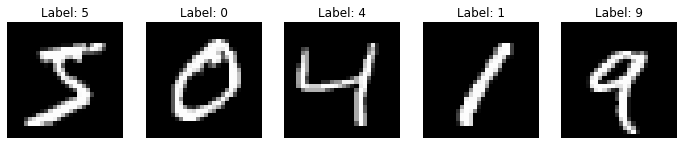

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # Create a row of 5 images
for i in range(5):
    image, label = full_train_data[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # Turn off the axes for clarity
plt.show()